# Machine Learning Exercise 7 - K-Means Clustering & PCA

This notebook covers a Python-based solution for the seventh programming exercise of the machine learning class on Coursera.  Please refer to the [exercise text](https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex7.pdf) for detailed descriptions and equations.

In this exercise we'll implement K-means clustering and use it to compress an image.  We'll start with a simple 2D data set to see how K-means works, then we'll apply it to image compression.  We'll also experiment with principal component analysis and see how it can be used to find a low-dimensional representation of images of faces.

## K-means clustering

To start out we're going to implement and apply K-means to a simple 2-dimensional data set to gain some intuition about how it works.  K-means is an iterative, unsupervised clustering algorithm that groups similar instances together into clusters.  The algorithm starts by guessing the initial centroids for each cluster, and then repeatedly assigns instances to the nearest cluster and re-computes the centroid of that cluster.  The first piece that we're going to implement is a function that finds the closest centroid for each instance in the data.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random
from scipy.io import loadmat
%matplotlib inline

# Import du fichier ex7data2.mat + formatage des donnees

In [2]:
## indice : loadmat
data = loadmat('data/ex7data2.mat')

In [3]:
dataset = pd.DataFrame(data=data['X'], columns=['X1', 'X2'])
dataset.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


Text(0,0.5,'X2')

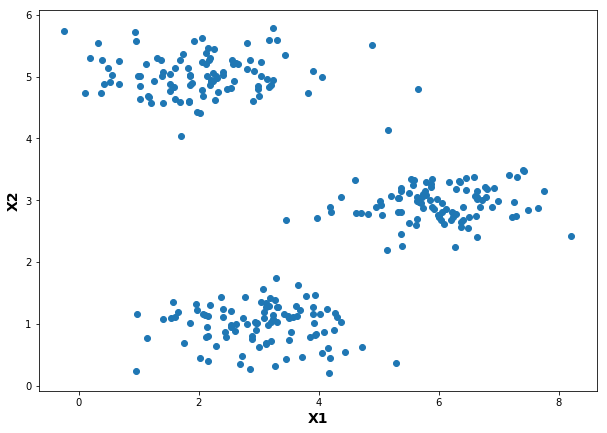

In [4]:
plt.figure(figsize = (10, 7))
plt.scatter(dataset['X1'], dataset['X2'], marker = 'o')
plt.xlabel('X1',fontsize='14', fontweight='bold')
plt.ylabel('X2', fontsize='14', fontweight='bold')

In [5]:
#X = np.array([dataset['X1'],dataset['X2']]).T
X = data['X']
X.shape

(300, 2)

In [10]:
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=3, max_iter=120)

In [11]:
km1.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=120,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

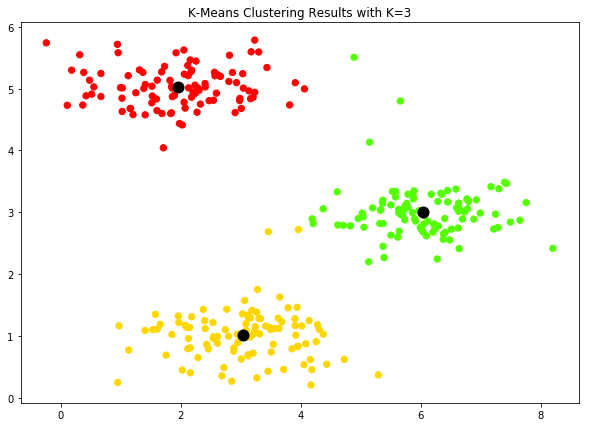

In [23]:
plt.figure(figsize = (10, 7))
plt.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
plt.title('K-Means Clustering Results with K=3')
plt.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='o', s=100, c='k', linewidth=2);

In [13]:
km1.cluster_centers_

array([[ 1.95399466,  5.02557006],
       [ 3.04367119,  1.01541041],
       [ 6.03366736,  3.00052511]])

# Initialisation des centres a la .main

In [15]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Coder la fonction qui permet de trouver le centre le plus proche

In [16]:
def find_closest_centroids(X, centroids):  
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    for i in range(m):
        minJ = 1000
        for j in range(k):
            J = np.sum((X[i] - centroids[j])**2)
            if J < minJ:
                minJ = J
                idx[i] = j
    return idx

Let's test the function to make sure it's working as expected.  We'll use the test case provided in the exercise.

The output matches the expected values in the text (remember our arrays are zero-indexed instead of one-indexed so the values are one lower than in the exercise).  Next we need a function to compute the centroid of a cluster.  The centroid is simply the mean of all of the examples currently assigned to the cluster.

# Ecrire la fonction qui met a jouer les K centres

In [17]:
...
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    for j in range(k):
        count = 0
        csum = 0
        for i in range(m):
            if idx[i] == j:
                csum += X[i]
                count += 1
        centroids[j] = csum / count
    return centroids
...

def compute_centroids(X, idx, k):  
    m, n = X.shape
    centroids = np.zeros((k, n))
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    return centroids

In [18]:
idx = find_closest_centroids(X, initial_centroids)
compute_centroids(X, idx, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

expected output : array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

This output also matches the expected values from the exercise.  So far so good.  The next part involves actually running the algorithm for some number of iterations and visualizing the result.  This step was implmented for us in the exercise, but since it's not that complicated I'll build it here from scratch.  In order to run the algorithm we just need to alternate between assigning examples to the nearest cluster and re-computing the cluster centroids.

# Ecrire la fonction K-means qui fait tourner l'algo

In [19]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    return idx, centroids

In [20]:
idx, centroids = run_k_means(X, initial_centroids, 10)
centroids

array([[ 1.95399466,  5.02557006],
       [ 3.04367119,  1.01541041],
       [ 6.03366736,  3.00052511]])

expected output : array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

In [14]:
km1.cluster_centers_

array([[ 1.95399466,  5.02557006],
       [ 3.04367119,  1.01541041],
       [ 6.03366736,  3.00052511]])

# Executer le code suivant pour la visualisation des differents clusters obtenus

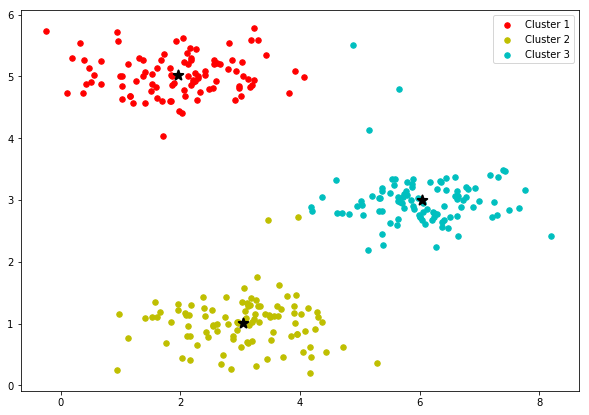

In [21]:
cluster1 = X[np.where(idx == 0)[0],:]  
cluster2 = X[np.where(idx == 1)[0],:]  
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(10,7))  
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')  
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='y', label='Cluster 2')  
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='c', label='Cluster 3')  
plt.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='*', s=100, c='k', linewidth=2);
ax.legend()  

One step we skipped over is a process for initializing the centroids.  This can affect the convergence of the algorithm.  We're tasked with creating a function that selects random examples and uses them as the initial centroids.

# Ecrire la fonction qui initialise K centroides de maniere aleatoire

In [35]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    rdm = np.random.randint(0, m, k)
    for i in range(k):
        centroids[i,:] = X[rdm[i],:]
    return centroids

In [32]:
help (np.random)

Help on package numpy.random in numpy:

NAME
    numpy.random

DESCRIPTION
    Random Number Generation
    
    ==================== =========================================================
    Utility functions
    random_sample        Uniformly distributed floats over ``[0, 1)``.
    random               Alias for `random_sample`.
    bytes                Uniformly distributed random bytes.
    random_integers      Uniformly distributed integers in a given range.
    permutation          Randomly permute a sequence / generate a random sequence.
    shuffle              Randomly permute a sequence in place.
    seed                 Seed the random number generator.
    choice               Random sample from 1-D array.
    
    ==================== =========================================================
    
    ==================== =========================================================
    Compatibility functions
    rand                 Uniformly distributed values.
    randn

In [36]:
init_centroids(X, 3)

array([[ 2.06995345,  4.6846713 ],
       [ 0.94048944,  5.71556802],
       [ 6.72798098,  3.0043983 ]])

Our next task is to apply K-means to image compression.  The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments.  Here's the image we're going to compress.

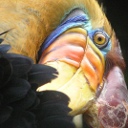

In [37]:
from IPython.display import Image
Image(filename='data/bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [38]:
image_data = loadmat('data/bird_small.mat')
image_data

{'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ..., 
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ..., 
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ..., 
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ..., 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ..., 
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ..., 
         [ 80,  38,  40],
         [ 68,  39,  40],
         [ 59,  43,  42]],
 
        [[ 15,  19,  19],
         [ 20,  20,  18],
         [ 18,  19,  17],
         ..., 
         [ 65,  43

In [39]:
A = image_data['A']
A.shape

(128, 128, 3)

Now we need to apply some pre-processing to the data and feed it into the K-means algorithm.

In [9]:
# # normalize value ranges
A = A / 255.

# # reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

In [14]:
# initialise les centres de maniere aleatoire


# lance l'algorithme


# trouve les centres les plus proches 


# place chaque pixel par rapport a son centre de reference



In [8]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

In [7]:
plt.imshow(X_recovered)

Cool!  You can see that we created some artifacts in the compression but the main features of the image are still there.  That's it for K-means.  We'll now move on to principal component analysis.

## Principal component analysis

PCA is a linear transformation that finds the "principal components", or directions of greatest variance, in a data set.  It can be used for dimension reduction among other things.  In this exercise we're first tasked with implementing PCA and applying it to a simple 2-dimensional data set to see how it works.  Let's start off by loading and visualizing the data set.

In [15]:
#loadmat ex7data1.mat
data =
data

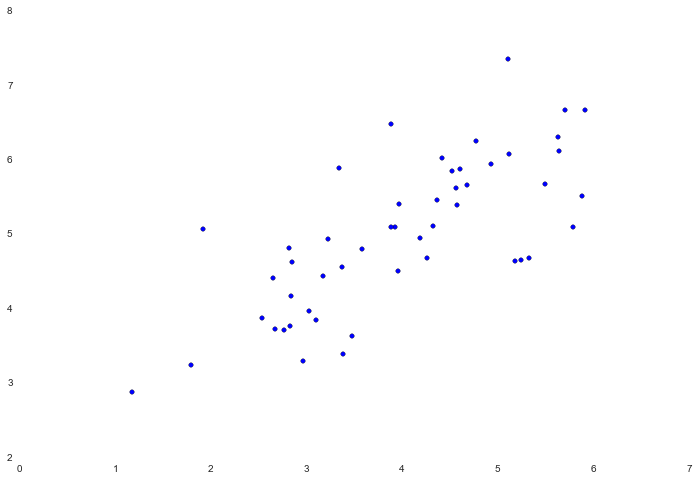

In [19]:
X = data['X']

#plt.subplots 
fig, ax =
ax.scatter(X[:, 0], X[:, 1])

The algorithm for PCA is fairly simple.  After ensuring that the data is normalized, the output is simply the singular value decomposition of the covariance matrix of the original data.

In [20]:
def pca(X):
    # normalize the features
    
    # compute the covariance matrix
    
    # perform SVD (man np.linalg)
    
    return U, S, V

In [16]:
#use the pca function
U, S, V

Now that we have the principal components (matrix U), we can use these to project the original data into a lower-dimensional space.  For this task we'll implement a function that computes the projection and selects only the top K components, effectively reducing the number of dimensions.

In [22]:
def project_data(X, U, k):
    U_reduced = 

In [17]:
Z = 

We can also attempt to recover the original data by reversing the steps we took to project it.

In [24]:
def recover_data(Z, U, k):
    U_reduced = 

In [18]:
X_recovered =

In [19]:
fig, ax = 
ax.scatter(X_recovered[:, 0], X_recovered[:, 1])

Notice that the projection axis for the first principal component was basically a diagonal line through the data set.  When we reduced the data to one dimension, we lost the variations around that diagonal line, so in our reproduction everything falls along that diagonal.

Our last task in this exercise is to apply PCA to images of faces.  By using the same dimension reduction techniques we can capture the "essence" of the images using much less data than the original images.

In [20]:
# data/ex7faces.mat
faces = 
X = faces['X']
#regarder la dimension des donnees

The exercise code includes a function that will render the first 100 faces in the data set in a grid.  Rather than try to re-produce that here, you can look in the exercise text for an example of what they look like.  We can at least render one image fairly easily though.

In [28]:
#np reshape the X to a 32, 32 matrix using line 3
face =

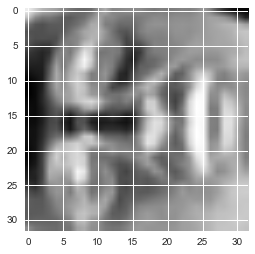

In [29]:
plt.imshow(face)

Yikes, that looks awful.  These are only 32 x 32 grayscale images though (it's also rendering sideways, but we can ignore that for now).  Anyway's let's proceed.  Our next step is to run PCA on the faces data set and take the top 100 principal components.

In [30]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

Now we can attempt to recover the original structure and render it again.

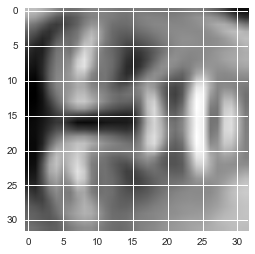

In [31]:
X_recovered = recover_data(Z, U, 100)
#reshape X_recovered
face = 
plt.imshow(face)

Observe that we lost some detail, though not as much as you might expect for a 10x reduction in the number of dimensions.

That concludes exercise 7.  In the final exercise we'll implement algorithms for anomaly detection and build a recommendation system using collaborative filtering.